# Climate Risk Analysis Pipeline (Final)

This notebook demonstrates the complete end-to-end analysis pipeline for the Climate Risk Scoring Dashboard. 
It uses **real data** collected from NASA POWER (Climate) and World Bank (Socioeconomic) for all 28 Malawian districts.

## Objectives
1. **Load Real Data**: Import processed climate and socioeconomic datasets.
2. **Calculate Indicators**: Compute rainfall variability, drought frequency, and heat days from daily records.
3. **Score Risk**: Apply the IPCC-aligned risk scoring methodology.
4. **visualize Results**: Analyze risk distribution and key drivers.

In [17]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path to import project modules
sys.path.append('../src')

from config import ALL_DISTRICTS
from scoring_engine import RiskScorer
from data_processing import (
    calculate_rainfall_cv,
    calculate_heat_days,
    calculate_drought_frequency,
    calculate_extreme_rainfall_frequency,
    robust_normalize
)
from data_collection import calculate_cyclone_exposure

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("husl")

## 1. Load Real Data

We load the clean, processed datasets from the `data/processed/` directory.

In [18]:
# Define paths
DATA_DIR = '../data/processed'
CLIMATE_FILE = os.path.join(DATA_DIR, 'climate_data_nasa_power.csv')
SOCIO_FILE = os.path.join(DATA_DIR, 'socioeconomic_data_enhanced.csv')

# Load data
print(f"Loading climate data from {CLIMATE_FILE}...")
climate_df = pd.read_csv(CLIMATE_FILE)
climate_df['date'] = pd.to_datetime(climate_df['date'])

print(f"Loading socioeconomic data from {SOCIO_FILE}...")
socio_df = pd.read_csv(SOCIO_FILE)

print("\nData Loaded Successfully:")
print(f"- Climate Records: {len(climate_df):,} (2020-2024)")
print(f"- Socioeconomic Districts: {len(socio_df)}")

Loading climate data from ../data/processed\climate_data_nasa_power.csv...
Loading socioeconomic data from ../data/processed\socioeconomic_data_enhanced.csv...

Data Loaded Successfully:
- Climate Records: 51,156 (2020-2024)
- Socioeconomic Districts: 28


## 2. Calculate Climate Indicators

We derive hazard indicators directly from the daily weather data:
- **Rainfall Variability (CV)**: Coefficient of variation of annual rainfall.
- **Heat Days**: Number of days > 35°C.
- **Drought Frequency**: Percentage of months with severe rainfall deficit (SPI-based).
- **Flood Risk Proxy**: Frequency of extreme rainfall events (>95th percentile).

In [19]:
# Initialize results list
climate_indicators = []

for district in socio_df['district'].unique():
    # Filter data for district
    d_climate = climate_df[climate_df['district'] == district]
    
    # Calculate CV
    annual_rainfall = d_climate.groupby(d_climate['date'].dt.year)['rainfall'].sum()
    cv = (annual_rainfall.std() / annual_rainfall.mean() * 100) if annual_rainfall.mean() > 0 else 0
    
    # Calculate Heat Days (avg per year)
    total_heat_days = len(d_climate[d_climate['temperature_max'] > 35])
    avg_heat_days = total_heat_days / 5  # 5 years of data
    
    # Calculate Drought Frequency
    # Note: Using calculated function from src/data_processing.py
    drought_freq = calculate_drought_frequency(climate_df, district)
    if pd.isna(drought_freq): drought_freq = 0
    
    # Calculate Flood Risk Proxy (Extreme Rainfall Frequency)
    flood_freq = calculate_extreme_rainfall_frequency(climate_df, district)
    if pd.isna(flood_freq): flood_freq = 0
    
    climate_indicators.append({
        'district': district,
        'rainfall_cv': cv,
        'heat_days': avg_heat_days,
        'drought_frequency': drought_freq,
        'flood_risk_proxy': flood_freq
    })

climate_ind_df = pd.DataFrame(climate_indicators)
print("Climate Indicators Calculated (First 5):")
print(climate_ind_df.head())

Climate Indicators Calculated (First 5):
     district  rainfall_cv  heat_days  drought_frequency  flood_risk_proxy
0      Balaka    27.711519       27.8                0.0          5.035577
1    Blantyre    18.385140       55.8                0.0          5.035577
2    Chikwawa    18.385140       55.8                0.0          5.035577
3  Chiradzulu    23.509707       35.6                0.0          5.035577
4     Chitipa    30.300856        0.0                0.0          5.035577


## 3. Prepare Full Input Dataset

Combine climate indicators, socioeconomic data, and cyclone exposure calculations.

In [20]:
# Merge datasets
full_data = socio_df.merge(climate_ind_df, on='district')

# Calculate cyclone exposure based on latitude
full_data['cyclone_exposure'] = full_data['district'].apply(
    lambda x: calculate_cyclone_exposure(x, ALL_DISTRICTS[x]['lat'])
)

# Derive Exposure Indicators
full_data['infrastructure_deficit'] = 100 - full_data['road_density']
full_data['exposed_population'] = full_data['population_density']
full_data['cropland_exposure'] = full_data['agricultural_dependence']

# Add Adaptive Capacity components
full_data['education_level'] = full_data['literacy_rate']
full_data['service_access'] = (full_data['health_facility_access'] + full_data['water_access']) / 2
full_data['local_capacity'] = 100 - full_data['poverty_rate']

print("Full Input Dataset Computed.")

Full Input Dataset Computed.


## 4. Normalize Indicators

Normalize all raw values to a 0-100 scale using robust normalization.

In [21]:
# Normalize Hazard
full_data['norm_rainfall_variability'] = robust_normalize(full_data['rainfall_cv'].values)
full_data['norm_drought_frequency'] = robust_normalize(full_data['drought_frequency'].values)
full_data['norm_flood_risk'] = robust_normalize(full_data['flood_risk_proxy'].values)
full_data['norm_heat_days'] = robust_normalize(full_data['heat_days'].values)
# Cyclone exposure is already 0-100

# Normalize Exposure
full_data['norm_exposed_pop'] = robust_normalize(full_data['exposed_population'].values)
full_data['norm_ag_dependence'] = robust_normalize(full_data['agricultural_dependence'].values)
full_data['norm_infra_deficit'] = robust_normalize(full_data['infrastructure_deficit'].values)
full_data['norm_cropland'] = robust_normalize(full_data['cropland_exposure'].values)

# Normalize/Prepare Adaptive Capacity (Already roughly 0-100, but ensuring bounds)
full_data['norm_poverty'] = full_data['poverty_rate'].clip(0, 100)
full_data['norm_education'] = full_data['education_level'].clip(0, 100)
full_data['norm_services'] = full_data['service_access'].clip(0, 100)
full_data['norm_capacity'] = full_data['local_capacity'].clip(0, 100)

## 5. Calculate Risk Scores

Using the `RiskScorer` engine from `src/scoring_engine.py`.

In [22]:
scorer = RiskScorer()
results = []

for _, row in full_data.iterrows():
    hazard_dict = {
        'rainfall_variability': row['norm_rainfall_variability'],
        'drought_frequency': row['norm_drought_frequency'],
        'flood_risk': row['norm_flood_risk'],
        'temperature_extremes': row['norm_heat_days'],
        'cyclone_exposure': row['cyclone_exposure']
    }
    
    exposure_dict = {
        'exposed_population': row['norm_exposed_pop'],
        'agricultural_dependence': row['norm_ag_dependence'],
        'infrastructure_deficit': row['norm_infra_deficit'],
        'cropland_exposure': row['norm_cropland']
    }
    
    capacity_dict = {
        'poverty_rate': row['norm_poverty'],
        'education_level': row['norm_education'],
        'service_access': row['norm_services'],
        'local_capacity': row['norm_capacity']
    }
    
    scores = scorer.calculate_all_scores(hazard_dict, exposure_dict, capacity_dict)
    scores['district'] = row['district']
    results.append(scores)

risk_scores = pd.DataFrame(results)
print(f"Risk Scores Calculated for {len(risk_scores)} districts.")

Risk Scores Calculated for 28 districts.


## 6. Analysis & Visualization

C:\Users\Dell Celestial\AppData\Local\Temp\ipykernel_49932\243772388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_risk, x='risk', y='district', palette='Reds_r')


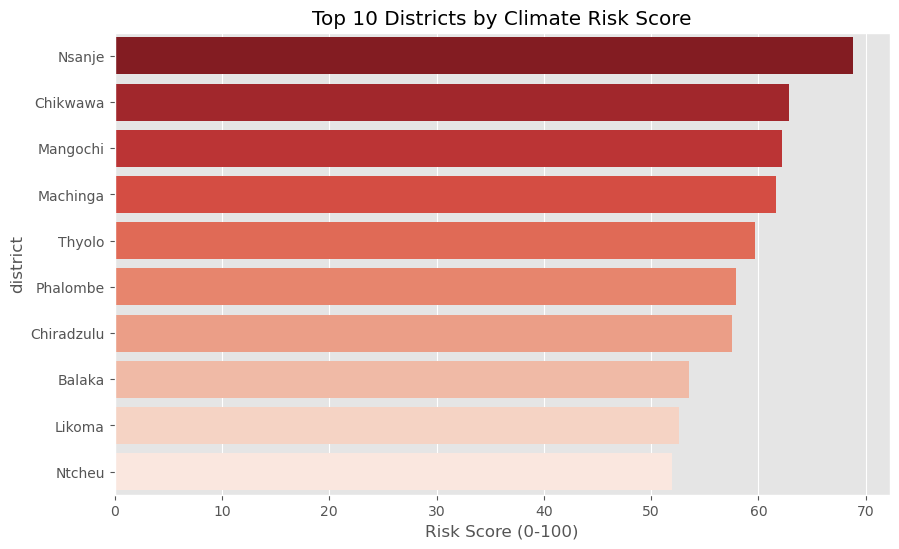

In [23]:
# Top 10 High Risk Districts
top_risk = risk_scores.sort_values('risk', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_risk, x='risk', y='district', palette='Reds_r')
plt.title('Top 10 Districts by Climate Risk Score')
plt.xlabel('Risk Score (0-100)')
plt.show()

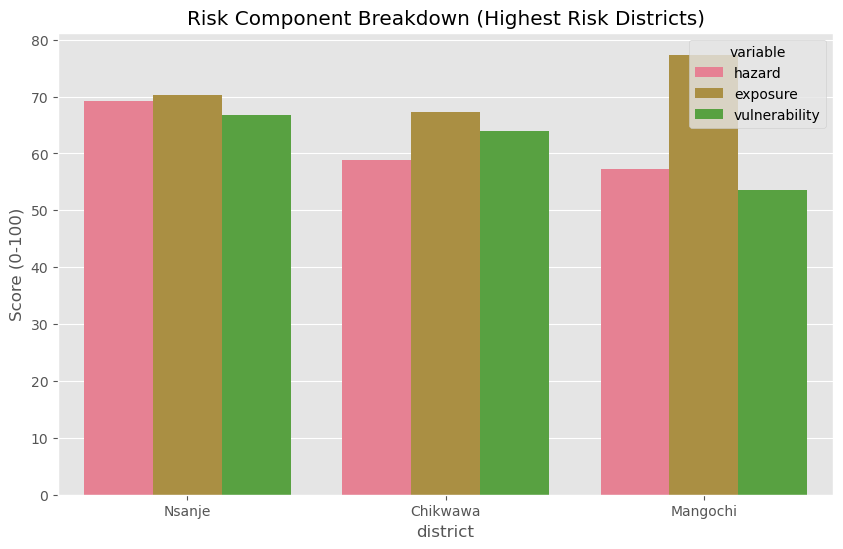

In [24]:
# Component Breakdown for Top 3 Districts
top_3 = risk_scores.sort_values('risk', ascending=False).head(3)
melted = top_3.melt(id_vars='district', value_vars=['hazard', 'exposure', 'vulnerability'])

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='district', y='value', hue='variable')
plt.title('Risk Component Breakdown (Highest Risk Districts)')
plt.ylabel('Score (0-100)')
plt.show()